<a href="https://colab.research.google.com/github/NathanDietrich/Artificial-Intelligence-and-Machine-Learning-portfolio/blob/main/Experiment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=5062b160f4a3c7e55689fb80a927bb598bb9ac2bcd3fa4b04f47b387fa28a168
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


[*********************100%***********************]  9 of 9 completed


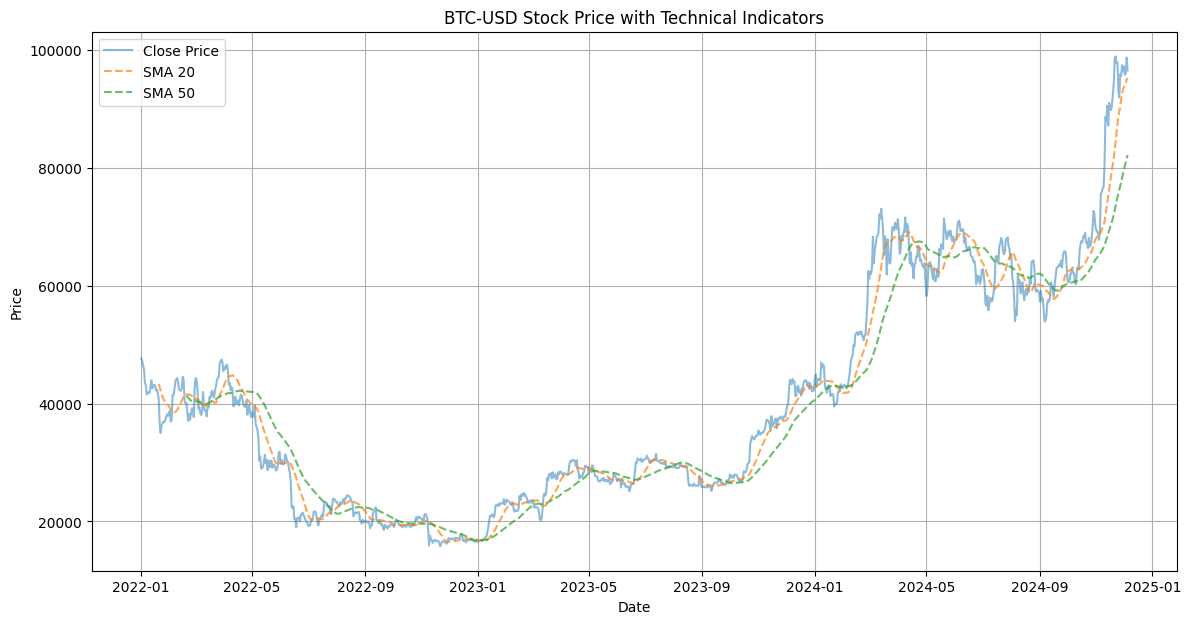

In [26]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# List of stocks
# stocks = [
#     'MSFT', 'GOOGL', 'AMZN', 'META', 'IBM',
#     'NVDA', 'TSLA', 'BIDU', 'INTC', 'ORCL', 'BTC_USD'
# ]

stocks = [
    'MSFT', 'GOOGL', 'META', 'IBM',
    'NVDA', 'TSLA', 'INTC', 'ORCL', 'BTC-USD'
]

# Static interest rates
interest_rates = {
    "United States": 4.75,
    "China": 3.35,
    "United Kingdom": 4.75,
    "Ukraine": 13.0,
    "Bhutan": 6.8,
    "El Salvador": 5.37,
    "Russia": 21.0,
    "Iran": 23.0,
    "Israel": 4.5,
    "Taiwan": 2.0,
    "Japan": 0.25
}

def get_stock_data(symbols, start_date, end_date):
    data = yf.download(symbols, start=start_date, end=end_date, group_by='ticker')
    return data

def add_technical_indicators(data):
    indicator_data = {}
    for ticker in data.columns.levels[0]:
        ticker_data = data[ticker].copy()
        ticker_data['SMA_20'] = ticker_data['Close'].rolling(window=20).mean()
        ticker_data['SMA_50'] = ticker_data['Close'].rolling(window=50).mean()
        rsi = RSIIndicator(ticker_data['Close'], window=14)
        ticker_data['RSI'] = rsi.rsi()
        macd = MACD(ticker_data['Close'], window_slow=26, window_fast=12, window_sign=9)
        ticker_data['MACD'] = macd.macd()
        ticker_data['MACD_Signal'] = macd.macd_signal()
        bb = BollingerBands(ticker_data['Close'], window=20, window_dev=2)
        ticker_data['BB_High'] = bb.bollinger_hband()
        ticker_data['BB_Low'] = bb.bollinger_lband()
        indicator_data[ticker] = ticker_data

    return pd.concat(indicator_data, axis=1)

def add_interest_rates(data, interest_rates):
    interest_rate_df = pd.DataFrame(
        {f'Interest_Rate_{country.replace(" ", "_")}': rate for country, rate in interest_rates.items()},
        index=data.index
    )
    # Convert interest rate columns to a MultiIndex to maintain consistency
    interest_rate_df.columns = pd.MultiIndex.from_product([['Interest_Rates'], interest_rate_df.columns])
    return pd.concat([data, interest_rate_df], axis=1)

def trading_strategy(data, model, scaler, lookback=30):
    # Assuming data is a MultiIndex DataFrame with (ticker, attribute) columns
    signals = pd.DataFrame(index=data.index)
    tickers = [t for t in data.columns.levels[0] if t in stocks]

    # Define the features used by the LSTM model (must match your training setup)
    # For example, if during training you used these features:
    features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']

    for ticker in tickers:
        # Initialize all signals to 'Hold'
        signals[ticker] = 'Hold'

        # Extract the ticker-specific data
        ticker_data = data[ticker].dropna()

        # If not enough data for lookback, continue
        if len(ticker_data) <= lookback:
            continue

        # Get the feature matrix and scale it
        X = ticker_data[features].values
        X_scaled = scaler.transform(X)

        # Generate sequences of shape (samples, lookback, features)
        X_seq = []
        for i in range(len(X_scaled) - lookback):
            X_seq.append(X_scaled[i:i+lookback])

        X_seq = np.array(X_seq)

        # Make predictions with the LSTM model
        # Predictions shape: (number_of_samples, 1)
        preds = model.predict(X_seq)

        # Convert probabilities to Buy/Sell signals
        # If prediction > 0.5 => Buy, else Sell
        pred_signals = np.where(preds.flatten() > 0.5, 'Buy', 'Sell')

        # Align the predictions with the appropriate dates
        # The first prediction corresponds to the day after the first lookback window
        pred_dates = ticker_data.index[lookback:]

        # Create a temporary DataFrame of signals
        temp_signals = pd.DataFrame(pred_signals, index=pred_dates, columns=[ticker])

        # Update the main signals DataFrame
        signals.update(temp_signals)

    return signals

def plot_data(data, ticker):
    plt.figure(figsize=(14, 7))
    ticker_data = data[ticker]
    plt.plot(ticker_data['Close'], label='Close Price', alpha=0.5)
    plt.plot(ticker_data['SMA_20'], label='SMA 20', linestyle='--', alpha=0.7)
    plt.plot(ticker_data['SMA_50'], label='SMA 50', linestyle='--', alpha=0.7)
    plt.title(f'{ticker} Stock Price with Technical Indicators')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()


start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp('2024-12-06')

raw_data = get_stock_data(stocks, start_date, end_date)
data = add_technical_indicators(raw_data)
data = add_interest_rates(data, interest_rates)
#signals = trading_strategy(data)

plot_data(data, 'BTC-USD')
#print(signals[['BTC-USD']].tail())


In [19]:
print(data.columns)

MultiIndex([(       'BTC_USD',                         'Open'),
            (       'BTC_USD',                         'High'),
            (       'BTC_USD',                          'Low'),
            (       'BTC_USD',                        'Close'),
            (       'BTC_USD',                    'Adj Close'),
            (       'BTC_USD',                       'Volume'),
            (       'BTC_USD',                       'SMA_20'),
            (       'BTC_USD',                       'SMA_50'),
            (       'BTC_USD',                          'RSI'),
            (       'BTC_USD',                         'MACD'),
            ...
            ('Interest_Rates',          'Interest_Rate_China'),
            ('Interest_Rates', 'Interest_Rate_United_Kingdom'),
            ('Interest_Rates',        'Interest_Rate_Ukraine'),
            ('Interest_Rates',         'Interest_Rate_Bhutan'),
            ('Interest_Rates',    'Interest_Rate_El_Salvador'),
            ('Interest_R

[*********************100%***********************]  1 of 1 completed

Ticker           BTC-USD                                            \
Price               Open          High           Low         Close   
Date                                                                 
2022-01-01  46311.746094  47827.312500  46288.484375  47686.812500   
2022-01-02  47680.925781  47881.406250  46856.937500  47345.218750   
2022-01-03  47343.542969  47510.726562  45835.964844  46458.117188   
2022-01-04  46458.851562  47406.546875  45752.464844  45897.574219   
2022-01-05  45899.359375  46929.046875  42798.222656  43569.003906   
...                  ...           ...           ...           ...   
2022-12-26  16842.250000  16920.123047  16812.369141  16919.804688   
2022-12-27  16919.291016  16959.845703  16642.072266  16717.173828   
2022-12-28  16716.400391  16768.169922  16497.556641  16552.572266   
2022-12-29  16552.322266  16651.755859  16508.683594  16642.341797   
2022-12-30  16641.330078  16643.427734  16408.474609  16602.585938   

Ticker             